# B1: Face Shape Classifier - SVM

# Import the required libraries

In [99]:
import numpy as np
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import features_extraction_B as feB
import warnings
warnings.filterwarnings("ignore")

# Feature Extraction and Data Split

In [4]:
# extract face shape features and labels from images by landmarks
startTime = time.clock()

task = 'B1'
test = 0
X_cartoon, y_face, _ = feB.extract_features_labels(test, task)   # obtain 68 facial features given an (128*128) image 
print(X_cartoon.shape)

endTime = time.clock()
runTime = endTime - startTime
print('The running time is',runTime,'s')

(7766, 68, 2)
The running time is 169.2298001 s


In [43]:
X_cartoon_jaw = X_cartoon[:,0:17,:]    # the first 17 features indicate the jaw
print(X_cartoon_jaw.shape)

(7766, 17, 2)


In [17]:
# split data into training set and validation set
def data_split(X, y_label, test_size):
    X_train, X_val, y_train, y_val = train_test_split(X, y_label, test_size=test_size, random_state=1)
   
    X_train = X_train.reshape(len(X_train), 17*2)
    X_val = X_val.reshape(len(X_val), 17*2)   #only need 17*2 data for each image

    return X_train, X_val, y_train, y_val

In [31]:
# pre-processing
y_label = y_face  # B1
test_size = 0.3
X_train, X_val, y_train, y_val = data_split(X_cartoon_jaw, y_label, test_size)

print(X_train.shape)
print(y_val.shape)

(5436, 34)
(2330,)


# Build SVM Model

Test the following kernel functions implemented in the scikit learn library:
1. linear: \begin{align} <x,x'> \end{align}

2. polynomial: \begin{align} (\gamma <x,x'> +r)^d\end{align} 
3. rbf:\begin{align}e^{(-\gamma||x-x'||^2)} \end{align} 


In [94]:
# Build the SVM model with the optimized params found by GridSearchCV
def svmPredictCV(x_train, y_train, x_val):
    svmclf = svm.SVC()
    param_grid = [#{'kernel': ['linear'], 'C': [0.5,1,10,100]},
                  {'kernel': ['rbf'], 'gamma': [0.01], 'C': [2,3,4]},
                  #{'kernel': ['poly'], 'degree': [2,3], 'C': [0.5,1,10,100]}
                  ]
    grid_search = GridSearchCV(svmclf, param_grid, cv=3, scoring='accuracy', n_jobs=-1) 
    grid_search.fit(x_train, y_train)
    
    # print result dataframe  
    result = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]), pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
    print(result) 
    best_accuracy_score = grid_search.best_score_
    best_params = grid_search.best_params_
    print("Best: %f using %s" % (best_accuracy_score, best_params))
    
    # predict with the best classifier
    svmclf_cv = grid_search.best_estimator_
    y_pred = svmclf_cv.predict(x_val)
    
    return y_pred, svmclf_cv  

In [92]:
# TEST: Build the SVM model
def svmPredict(x_train,y_train, x_val):
    svmclf = svm.SVC(kernel='linear', C=10)
    svmclf.fit(x_train, y_train)
    y_pred = svmclf.predict(x_val)
    return y_pred, svmclf

In [95]:
# Train the SVM model
startTime = time.clock()

#best_accuracy_score, best_params = SVM_params(X_train, y_train, X_val, y_val)
#y_pred1, svmclf = svmPredict(X_train, y_train, X_val)
y_pred, svmclf_cv = svmPredictCV(X_train, y_train, X_val)
print(accuracy_score(y_val, y_pred1))

endTime = time.clock()
runTime = endTime - startTime
print('The running time is',runTime,'s')

   C  gamma kernel  Accuracy
0  2   0.01    rbf  0.664459
1  3   0.01    rbf  0.664643
2  4   0.01    rbf  0.666115
Best: 0.666115 using {'C': 4, 'gamma': 0.01, 'kernel': 'rbf'}
0.6180257510729614
The running time is 8.336850200001209 s


# Assessment

In [47]:
# plot learning curve; developed by sklearn official document
def plot_learning_curve(estimator, X, y):
    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y)  #train_sizes=np.linspace(.1, 1.0, 5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    #plt.savefig(title+'.png')

    return plt, np.mean(train_scores_mean)

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       428
           1       0.62      0.63      0.62       427
           2       0.69      0.65      0.67       513
           3       0.66      0.62      0.64       484
           4       0.80      0.86      0.83       478

    accuracy                           0.69      2330
   macro avg       0.69      0.69      0.69      2330
weighted avg       0.69      0.69      0.69      2330



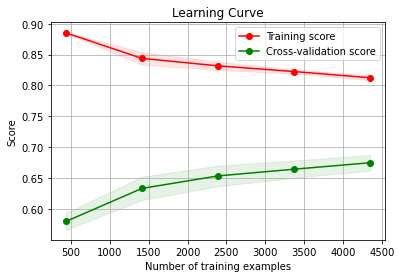

0.8391883434341741


In [98]:
#print(confusion_matrix(y_val, y_pred1))
print(classification_report(y_val,y_pred)) 
#acc_cv = cross_val_score(rf_optimized, X_all, y_smiling, scoring = 'accuracy', cv=5).mean()
#print('Accuracy score with 5-cross validation:', acc_cv)
plt, mean_score = plot_learning_curve(svmclf_cv, X_train, y_train)
plt.show()
print(mean_score)

In [110]:
# TEST: Build Random Forest Model 
def RanForPredict(x_train, y_train, x_val, n):
    rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_features=0.3, max_depth=8) 
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    return rf, y_pred

The running time is 0.780712300002051 s
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       428
           1       0.61      0.57      0.59       427
           2       0.68      0.65      0.67       513
           3       0.57      0.62      0.60       484
           4       0.79      0.86      0.82       478

    accuracy                           0.68      2330
   macro avg       0.68      0.67      0.67      2330
weighted avg       0.68      0.68      0.68      2330



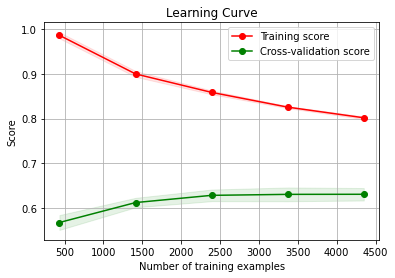

0.8745640878216557


In [111]:
startTime = time.clock()
rf, y_pred2 = RanForPredict(X_train, y_train, X_val, 100)
endTime = time.clock()
runTime = endTime - startTime
print('The running time is',runTime,'s')

#print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val,y_pred2)) 
#acc_cv = cross_val_score(rf_optimized, X_all, y_smiling, scoring = 'accuracy', cv=5).mean()
#print('Accuracy score with 5-cross validation:', acc_cv)
plt, mean_score = plot_learning_curve(rf, X_train, y_train)
plt.show()
print(mean_score)